# Step 1: Generating spectrograms from audio files (and some cleaning)

This script creates spectrograms from a list of input audio files.

#### The following minimal structure and files are required in the project directory:

    ├── audio
    │   ├── call_1.wav     <- call files 
    │   ├── call_2.wav     <- 
    │   ├── call_3.wav     <- 
    │   └── ...            <- 
    ├── data                  
    │   ├── info_file.csv  <- A ";"-separated csv file containing metadata about the calls
    ├── parameters         
    ├── ...  
    

#### The following structure is required for info_file.csv:

info_file.csv must contain at least the two columns: "filename" and "label". If labels are completely unknown, there should still be a label column with some NA identifiers (e.g "NA", "unknown", ...)

    | filename   | label   | ...    |  .... 
    -----------------------------------------
    | call_1.wav | alarm   |  ...   |  ....   
    | call_2.wav | contact |  ...   |  ....  
    | ...        |  ...    |  ...   |  ....   

#### The following files are generated in this script:
    
    ├── data               
    │   ├── df.pkl          <- pickled pandas dataframe with metadata, raw_audio and spectrograms
    ├── parameters
    │   ├── spec_params.py  <- a .py file containing the spectrogramming parameters that were used
    ├── ...    

## Import statements, constants and functions

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path
import umap
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, '..')

from functions.audio_functions import generate_mel_spectrogram, read_wavfile
from functions.preprocessing_functions import calc_zscore, pad_spectro


# Function for plotting example spectrograms

def plot_examples(df, random_indices, spec_type):
    
    if spec_type in df.columns:
    
        df_subset = df.iloc[random_indices,:]
        specs = df_subset[spec_type].values
        srs = df_subset.samplerate_hz.values

        plt.figure(figsize=(len(random_indices)*3,3))
        k=1
        for spec, sr in zip(specs,srs):
            plt.subplot(1, len(random_indices), k)
            librosa.display.specshow(spec,sr=sr, hop_length=int(FFT_HOP * sr) , fmin=FMIN, fmax=FMAX, y_axis='mel', x_axis='s',cmap='viridis')        
            plt.colorbar(format='%+2.0f dB')
            k+=1
        plt.suptitle(spec_type)
        plt.tight_layout()
    else:
        print("Error: ",spec_type, " not in df columns")

In [2]:

def plot_examples(df, random_indices, spec_type):
    
    if spec_type in df.columns:
    
        df_subset = df.iloc[random_indices,:]
        specs = df_subset[spec_type].values

        plt.figure(figsize=(len(random_indices)*3,3))
        
        for i,spec in enumerate(specs):
            plt.subplot(1, len(random_indices), i+1)
            plt.imshow(spec, origin='lower')
        plt.suptitle(spec_type)
        plt.tight_layout()
    else:
        print("Error: ",spec_type, " not in df columns")

In [3]:
BANDPASS_FILTER = False  # should bandpass-filtered spectrograms be generated?
MEDIAN_SUB = False  # should median-subtracted spectrograms be generated (reduce impulse noise)?
STRETCH = False    # should time-stretched spectrograms be generated (all stretched to max. duration in dataset)?

LABEL_COL = "label"     # name of column that contains labels
NA_DESCRIPTORS = [0, np.nan, "NA", "na", "not available", # values that indicate "no label"
                  "None", "Unknown", "unknown", None, ""]     # add your NA descriptor if not yet in list
                                                     
NEW_NA_INDICATOR = "unknown" # all vocalizations without label will be relabelled as "unknown"

PLOT_EXAMPLES = True # Plot example spectrograms after each step

In [4]:
BANDPASS_FILTER = True  # should bandpass-filtered spectrograms be generated?
MEDIAN_SUB = True  # should median-subtracted spectrograms be generated (reduce impulse noise)?
STRETCH = True    # should time-stretched spectrograms be generated (all stretched to max. duration in dataset)?


In [5]:
P_DIR = str(Path(os.getcwd()).parents[0])            # project directory
AUDIO_IN = os.path.join(os.path.sep, P_DIR, 'audio') # --> audio directory, contains audio (.wav) files
DATA = os.path.join(os.path.sep, P_DIR, 'data')      # --> empty data directory, output files will be put here


# Check if directories are present

if not os.path.isdir(AUDIO_IN):
    print("No audio directory found")

if not os.path.isdir(DATA):
    os.mkdir(DATA)

## 1. Read in files

In [6]:
df = pd.read_csv(os.path.join(os.path.sep, DATA, 'info_file.csv'), sep=";", index_col=[0])

In [7]:
df

,filename,label,indv,ori_label
26,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...,al,HMB,ALARM
27,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...,al,HMB,ALARM
28,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...,al,HMB,ALARM
29,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...,al,HMB,ALARM
30,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...,al,HMB,ALARM
...,...,...,...,...
18941,HM_VHMF001_HTB_R20_20190707-20190719_file_7_(2...,cc,VHMF001,cc $
13340,HM_RT_R12_file_5_(2017_08_24-06_44_59)_ASWMUX2...,cc,RT,CC
32998,HM_VHMM023_MBLS_R02_20190707-20190719_file_10_...,cc,VHMM023,cc
29707,HM_VHMM014_LSTB_R19_20190707-20190719_file_8_(...,cc,VHMM014,cc


#### Check if all audio files are in AUDIO_IN directory

In [8]:
audiofiles = df['filename'].values
files_in_audio_directory = os.listdir(AUDIO_IN)

In [9]:
missing_files = list(set(audiofiles) - set(files_in_audio_directory))
if len(missing_files)>0:
    print(len(missing_files), "files with no matching audio in audio folder: ", missing_files)

In [10]:
audio_filepaths = [os.path.join(os.path.sep, AUDIO_IN,x) for x in audiofiles]

## 2. Adding audio (and samplerate) to dataframe

In [11]:
raw_audio,samplerate_hz = map(list,zip(*[read_wavfile(x) for x in audio_filepaths]))

df['raw_audio'] = raw_audio
df['samplerate_hz'] = samplerate_hz

In [12]:
# Removing NA rows

nrows = df.shape[0]
df.dropna(subset=['raw_audio'], inplace=True)
print("Dropped ", nrows-df.shape[0], " rows due to missing/failed audio")

Dropped  0  rows due to missing/failed audio


## 3. Removing very long calls

It's advisable to remove very long calls, as all calls will be zero-padded to the maximum duration in the dataset.

In [13]:
# Extract duration of calls
df['duration_s'] = [x.shape[0] for x in df['raw_audio']]/df['samplerate_hz']

[Can be helpful to plot the distribution to find a good cutoff]

In [14]:
#%matplotlib inline
#n, bins, patches = plt.hist(df['duration_s'])

In our case, dataset was already cleaned and all calls were between 0-0.5s, so no need to remove long calls. Set MIN_DUR and MAX_DUR to values that make sense for your dataset.

In [15]:
MIN_DUR = 0  # --> minimum duration of calls in seconds
MAX_DUR = 0.5 # --> maximum duration of calls in seconds

In [16]:
print("Dropped ", df.loc[df['duration_s']<MIN_DUR,:].shape[0], "rows below ", MIN_DUR, "s (min_dur)")
df = df.loc[df['duration_s']>=MIN_DUR,:]
print("Dropped ", df.loc[df['duration_s']>MAX_DUR,:].shape[0], "rows above ", MAX_DUR, "s (max_dur)")
df = df.loc[df['duration_s']<=MAX_DUR,:]

Dropped  0 rows below  0 s (min_dur)
Dropped  0 rows above  0.5 s (max_dur)


## 4. Generate mel-spectrograms

In this step, spectrograms are generated from audio files via short-time fourier transformation. Spectrograms capture the frequency components of a signal over time. A spectrogram is a 2D matrix, where each value represents the signal intensity in a specific time (columns) and frequency bin (row). In this case, the frequency axis of the spectrograms are also Mel-transformed (a logarithmic scale) and signal intensity is expressed on a Decibel scale.

The following parameters define how the spectrograms are computed. You can leave this as default or choose your own parameters.

### 4.1. Set spectrogramming parameters

In [17]:
N_MELS = 40 # --> number of mel bins (usually 20-40)
            # The frequency bins are transformed to this number of logarithmically spaced mel bins.

FFT_WIN = 0.03 # --> length of audio chunk when applying STFT in seconds
               # FFT_WIN * samplerate = number of audio datapoints that go in one fft (=n_fft)

FFT_HOP = FFT_WIN/8 # --> hop_length in seconds
                    # FFT_HOP * samplerate = n of audio datapoints between successive ffts (=hop_length)

WINDOW = 'hann' # --> name of window function
                # each frame of audio is windowed by a window function. We use the window function 'hanning',  

FMIN = 0 # --> lower bound for frequency (in Hz) when generating Mel filterbank
FMAX = int(np.min(df['samplerate_hz'])/2) #--> upper bound for frequency (in Hz) when generating Mel filterbank
                                                 # this is set to 0.5 times the samplerate (-> Nyquist rule)
                                                 # If input files have different samplerates, the lowest samplerate is used
                                                 # to ensure all spectrograms have the same frequency resolution.

Save these parameters as they will be needed for all subsequent scripts

In [18]:
lines = ['N_MELS = '+str(N_MELS),
         'FFT_WIN = '+str(FFT_WIN),
         'FFT_HOP = '+str(FFT_HOP),
         'WINDOW = "'+str(WINDOW)+'"',
         'FMIN = '+str(FMIN),
         'FMAX = '+str(FMAX)]

with open(os.path.join(os.path.sep, P_DIR, 'parameters','spec_params.py'), 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

### 4.2. Generate spectrograms

This code produces mel-transformed spectrograms on Decibel scale.

In [19]:
spectrograms = df.apply(lambda row: generate_mel_spectrogram(data = row['raw_audio'],
                                                             rate = row['samplerate_hz'],
                                                             n_mels = N_MELS,
                                                             window = WINDOW,
                                                             fft_win = FFT_WIN,
                                                             fft_hop = FFT_HOP,
                                                             fmax = FMAX), 
                               axis=1)


df['spectrograms'] = spectrograms

In [20]:
# Removing NA rows

nrows = df.shape[0]
df.dropna(subset=['spectrograms'], inplace=True)
print("Dropped ", nrows-df.shape[0], " rows due to failed spectrogram generation")

Dropped  0  rows due to failed spectrogram generation


#### Show example spectrograms

In [21]:
n_examples = 3
random_indices = [random.randint(0,df.shape[0]) for x in [0]*n_examples]

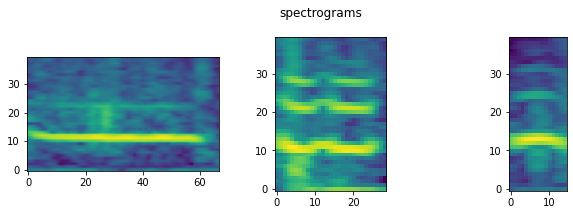

In [22]:
if PLOT_EXAMPLES: plot_examples(df, random_indices, 'spectrograms')

## [Optional:  Generate denoised spectrograms (median subtraction):]

Generate denoised spectrograms (denoised by median subtraction to reduce impulse noise) to have them available as an alternative input to UMAP:

In [23]:
if MEDIAN_SUB:
    df['denoised_spectrograms'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['spectrograms']]

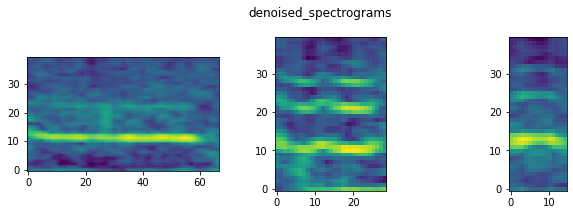

In [24]:
if PLOT_EXAMPLES: plot_examples(df, random_indices, 'denoised_spectrograms')

## [Optional : Generate denoised spectrograms (bandpass filter):]

Generate denoised spectrograms (denoised with a bandpass filter to reduce noise) to have them available as an alternative input to UMAP:

__Note that this means that different FMIN and FMAX are used for the spectrograms and you may also want to adapt N_MELS!!!__

In [25]:
LOWCUT = 300.0     # lower bound in Hz (all signals below this bound will be removed)  
HIGHCUT = 3000.0   # upper bound in Hz (all signals above this bound will be removed)  

In [26]:
if BANDPASS_FILTER:
    from functions.audio_functions import butter_bandpass_filter
    
    
    # create filtered audio
    df['filtered_audio'] = df.apply(lambda row: butter_bandpass_filter(data = row['raw_audio'],
                                                                       lowcut = LOWCUT,
                                                                       highcut = HIGHCUT,
                                                                       sr = row['samplerate_hz'],
                                                                       order = 6),
                               axis=1)

    # create spectrograms from filtered audio      
    df['filtered_spectrograms'] = df.apply(lambda row: generate_mel_spectrogram(data = row['filtered_audio'],
                                                                                rate = row['samplerate_hz'],
                                                                                n_mels = N_MELS,
                                                                                window = WINDOW,
                                                                                fft_win = FFT_WIN,
                                                                                fft_hop = FFT_HOP,
                                                                                fmax = HIGHCUT,
                                                                                fmin = LOWCUT
                                                                               ), 
                                           axis=1)

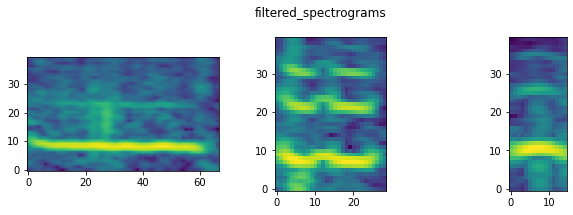

In [27]:
if PLOT_EXAMPLES: plot_examples(df, random_indices, 'filtered_spectrograms')

## [Optional:  Generate stretched spectrograms (all stretched to equal length)]

Stretch all calls to equal length, e.g. maximum length in the dataset (using phase vocoder algorithm) and generate spectrograms from these stretched calls.

In [28]:
if STRETCH:
    from functions.audio_functions import generate_stretched_mel_spectrogram
    
    MAX_DURATION = np.max(df['duration_s'])

    df['stretched_spectrograms'] = df.apply(lambda row: generate_stretched_mel_spectrogram(row['raw_audio'],
                                                                                           row['samplerate_hz'],
                                                                                           row['duration_s'],
                                                                                           N_MELS,
                                                                                           WINDOW,
                                                                                           FFT_WIN,
                                                                                           FFT_HOP,
                                                                                           MAX_DURATION),
                                            axis=1)

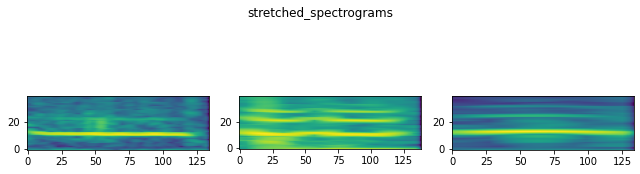

In [29]:
if PLOT_EXAMPLES: plot_examples(df, random_indices, 'stretched_spectrograms')

## [Optional: Create any combination of preprocessing steps]

It is also possible to combine different preprocessing steps. For example, I could apply median subtraction to the bandpass-filtered spectrograms:

In [30]:
if 'filtered_spectrograms' in df.columns:
    df['denoised_filtered_spectrograms'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['filtered_spectrograms']]

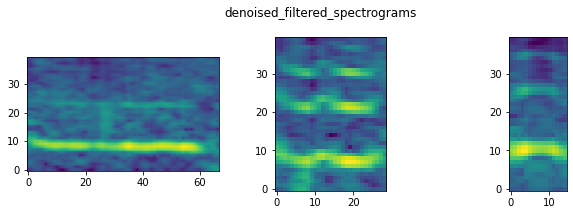

In [31]:
if PLOT_EXAMPLES: plot_examples(df, random_indices, 'denoised_filtered_spectrograms')

## 5. Clean labels

Make sure that all labels are strings and vocalizations with missing labels are labelled as "unknown"

In [27]:
df['original_label'] = df[LABEL_COL] #  original labels are saved in "original_label" column

df['label'] = ["unknown" if x in NA_DESCRIPTORS else x for x in df[LABEL_COL]]  # "unknown" for all NA labels
labels = df['label'].fillna(NEW_NA_INDICATOR) # double-check
df['label'] = labels.astype(str) # transform to strings and save in df as "label" column

## 6. Save dataframe

In [28]:
df.to_pickle(os.path.join(os.path.sep, DATA, 'df.pkl'))